In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from IPython.display import Image

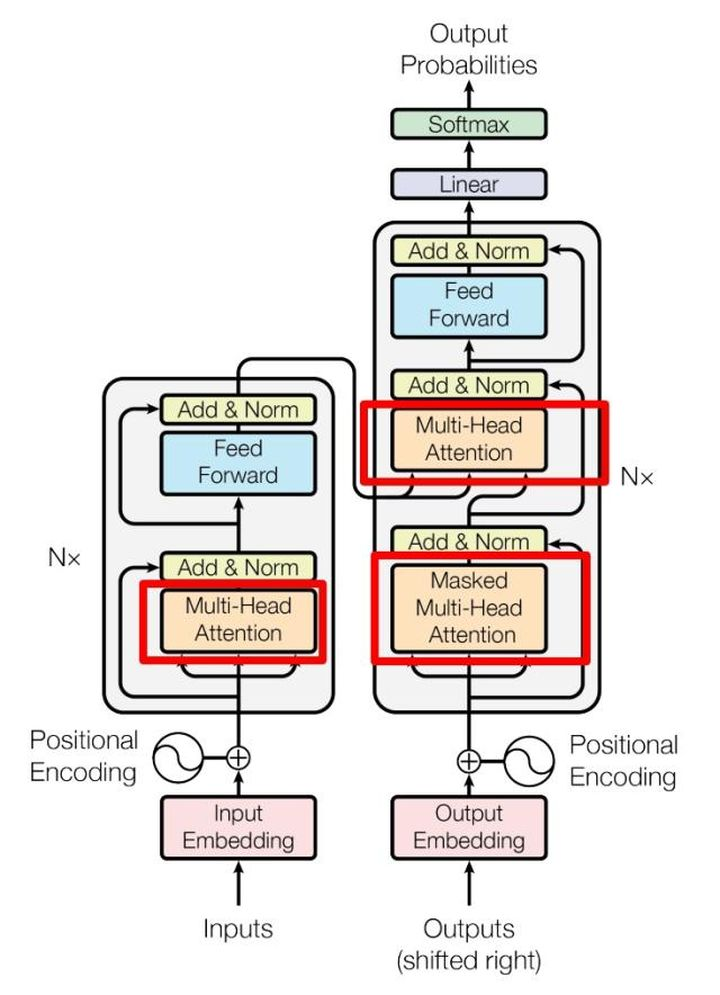

In [2]:
Image('figure/transformer.jpg',width=400,height=300)

In [3]:
## 模型参数
d_model = 512  # Embedding Size
d_ff = 2048  # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention


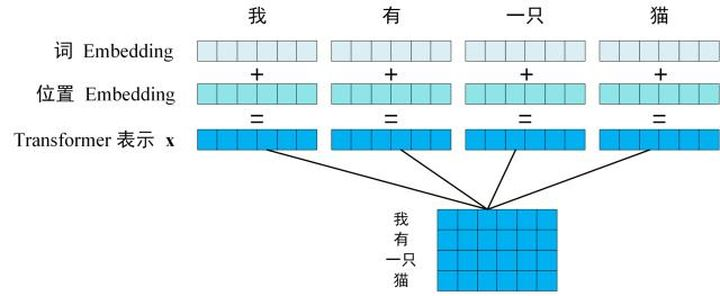

In [5]:
Image('figure/embedding.jpg',width=400,height=300)

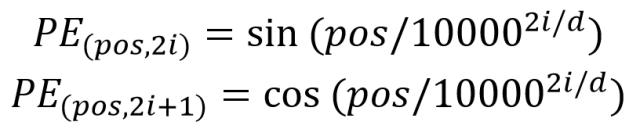

In [6]:
Image('figure/math.png',width=400,height=300)

In [52]:
# 位置编码的实现其实很简单，直接对照着公式去敲代码就可以，下面这个代码只是其中一种实现方式；
# 从理解来讲，需要注意的就是偶数和奇数在公式上有一个共同部分，我们使用ln函数把次方拿下来，方便计算；
# pos代表的是单词在句子中的索引，这点需要注意；比如max_len是128个，那么索引就是从0，1，2，...,127
# 假设我的demodel是512，2i那个符号中i从0取到了255，那么2i对应取值就是0,2,4...510
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        # max_len 5000 是定义输入模型的最大长度
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)  
        # 这个其实就是去定义生成一个矩阵进行 词embedding，大小是 [src_vocab_size,  d_model]
        
        pos = np.arange(max_len)[:, None]  # [max_len, 1]扩展一个维度为了后面矩阵运算
        pe = pos / np.power(10000, 2. * np.arange(d_model)[None, :] / d_model)  
        pe[:, 0::2] = np.sin(pe[:, 0::2])
        pe[:, 1::2] = np.cos(pe[:, 1::2])  # pe [max_len, dim]
        pe = torch.tensor(pe, dtype=torch.float)
        pe = pe.unsqueeze(0)   # pe[1, max_len, dim]  # 数据输入第一个维度为batch_size
                                
        self.register_buffer('pe', pe)  ## 定一个缓冲区，其实简单理解为这个参数不更新就可以
        
    def forward(self, x):
        # x [batch_size, seq_len]
        x = x + self.pe[:, :x.size(1), :]   # word embedding + positional embedding
        
        return x

# 多头注意力机制

## 多头注意力机制是由多个Self-Attention组成的
可以看到 Encoder block 包含一个 Multi-Head Attention，而 Decoder block 包含两个 Multi-Head Attention (其中有一个用到 Masked)。Multi-Head Attention 上方还包括一个 Add & Norm 层，Add 表示残差连接 (Residual Connection) 用于防止网络退化，Norm 表示 Layer Normalization，用于对每一层的激活值进行归一化。

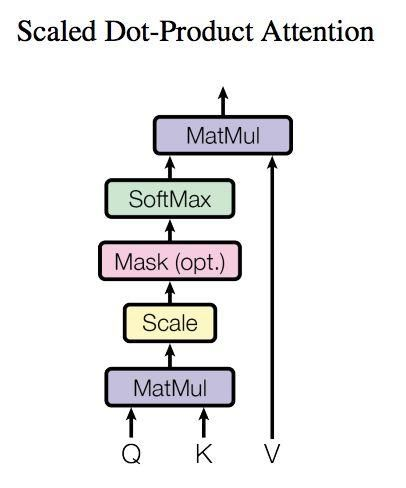

In [8]:
Image('figure/self-attention.jpg',width=400,height=300)

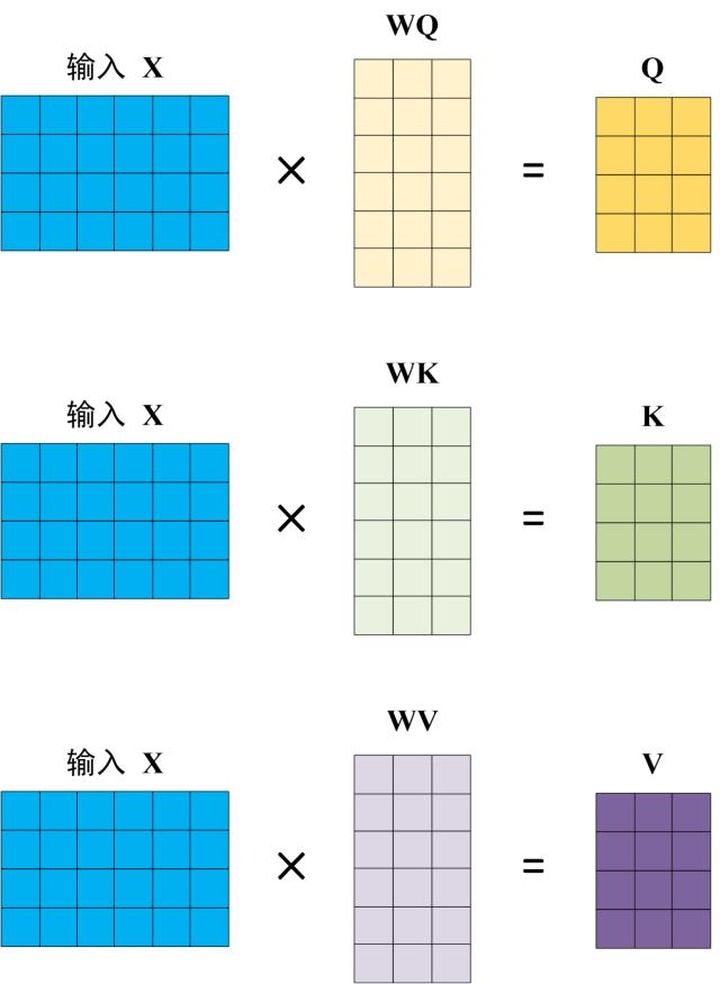

In [9]:
Image('figure/KQV.jpg',width=400,height=300)

### K、Q、V计算Self-Attention 的输入用矩阵X(seq_len, d_model)进行表示，则可以使用线性变阵矩阵(可以通过全连接层获得)WQ,WK,WV计算得到Q,K,V。计算如上图所示，注意 X, Q, K, V 的每一行都表示一个单词

## 得到矩阵 Q, K, V之后就可以计算出 Self-Attention 的输出了，计算的公式如下

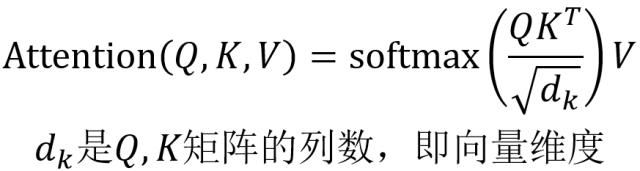

In [10]:
Image('figure/math2.jpg',width=400,height=300)

## 公式中计算矩阵Q和K每一行向量的内积，为了防止内积过大，因此除以 𝑑𝑘的平方根。Q乘以K的转置后，得到的矩阵行列数都为 n，n 为句子单词数，这个矩阵可以表示单词之间的 attention 强度。下图1234 表示的是句子中的单词

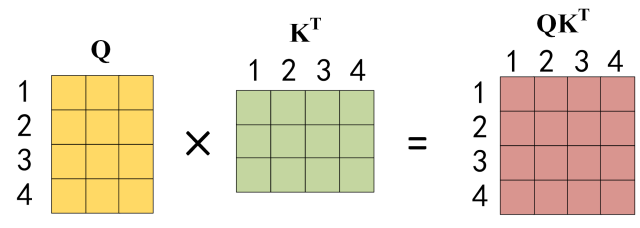

In [11]:
Image('figure/QK.png',width=400,height=300)

得到$QK^{T}$ 之后，使用 Softmax 计算每一个单词对于其他单词的 attention 系数，公式中的 Softmax 是对矩阵的每一行进行 Softmax，即每一行的和都变为 1

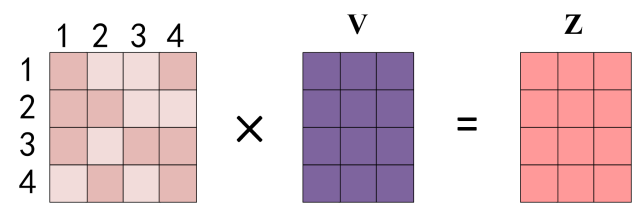

In [12]:
Image('figure/1.png',width=400,height=300)

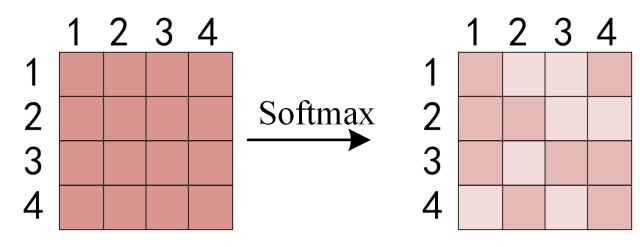

In [13]:
Image('figure/2.png',width=400,height=300)

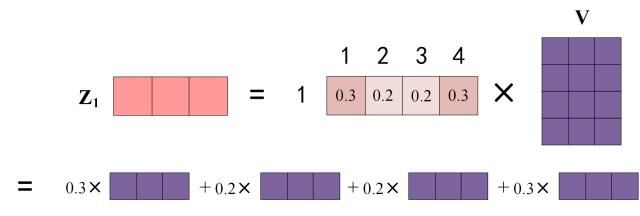

In [14]:
Image('figure/3.jpg',width=400,height=300)

## 在上一步，我们已经知道怎么通过 Self-Attention 计算得到输出矩阵 Z，而 Multi-Head Attention 是由多个 Self-Attention 组合形成的，下图是论文中 Multi-Head Attention 的结构图。对其输入的X进行分头计算 分头长度head_dim = d_model / n_heads

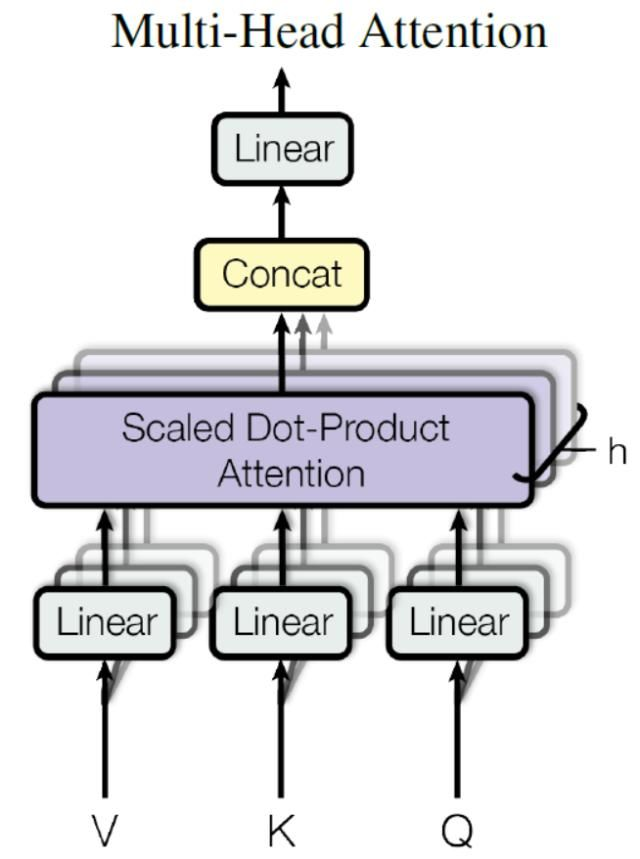

In [15]:
Image('figure/multi-head.jpg',width=400,height=300)

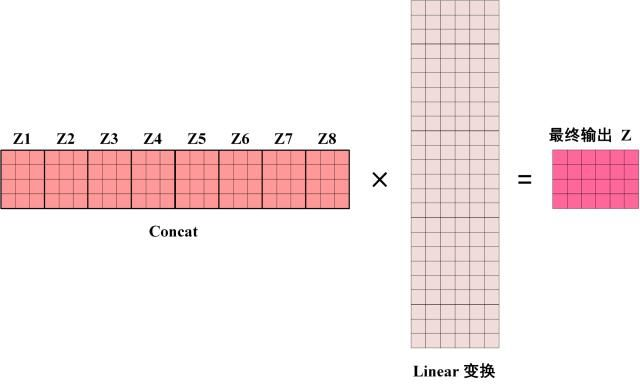

In [16]:
Image('figure/4.jpg',width=400,height=300)

In [53]:
# seq_q 和 seq_k 不一定一致，在交互注意力，q来自解码端，k,v来自编码端，所以告诉模型编码这边pad符号信息就可以，解码端的pad信息在交互注意力层是没有用到的；
def get_attn_pad_mask(seq_q, seq_k):
    # 输入 (batch_size, seq_len)
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # padding时 0作为Padding符号 然后后面被转换为1
    # eq(zero) is PAD token
    pad_attn_mask = torch.eq(seq_k, 0).float().unsqueeze(1)  # batch_size x 1 x len_k, one is masking eq元素等于0填充true 否则为false
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k expand复制维度

In [37]:
def get_attn_subsequent_mask(seq):
    """
    seq: [batch_size, tgt_len]
    """
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    # attn_shape: [batch_size, tgt_len, tgt_len]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)  # 生成一个上三角矩阵
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask  # [batch_size, tgt_len, tgt_len]

In [38]:
# 在交互注意力层K, V来自编码端而Q来自解码端
class MultiHeadAttention(nn.Module):
    def __init__(self):       
        super().__init__()
        self.head_dim = d_model // n_heads
        # 输入进来的QKV是相等的，使用映射linear做一个线性映射得到参数矩阵Wq, Wk,Wv
        self.W_Q = nn.Linear(d_model, self.head_dim * n_heads)
        self.W_K = nn.Linear(d_model, self.head_dim * n_heads)
        self.W_V = nn.Linear(d_model, self.head_dim * n_heads)
        self.linear = nn.Linear(self.head_dim * n_heads, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, Q, K, V, attn_mask):
        # 这个多头分为这几个步骤，首先映射分头，然后计算atten_scores，然后计算atten_value;
        # 输入进来的数据形状： Q: [batch_size x len_q x d_model], K: [batch_size x len_k x d_model], V: [batch_size x len_k x d_model]
        batch_size = Q.size(0)
        # 第一步先映射[batch_size, seq_len, n_heads*head_dim]
        # 第二步分头[batch_size, n_heads, seq_len, head_dim]将n_heads和seq_len交换位置方便运算
        Q = self.W_Q(Q).view(batch_size, -1, n_heads, self.head_dim).transpose(1,2)
        K = self.W_K(K).view(batch_size, -1, n_heads, self.head_dim).transpose(1,2)     
        V = self.W_V(V).view(batch_size, -1, n_heads, self.head_dim).transpose(1,2)
        
        # 输入进行的attn_mask形状是 batch_size x len_q x len_k，然后经过下面这个代码得到新的attn_mask : [batch_size x n_heads x len_q x len_k]，就是把pad信息重复了n个头上
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)

        # 然后我们计算 ScaledDotProductAttention attn是注意力矩阵用于可视化
        context, attn = self.scaled_dot_product_attention(Q, K, V, attn_mask) # contex [batch_size, n_heads, len_q, d_model]
        # pytorch 中不用contiguous()修改后面的值会导致前面的值发生改变
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * self.head_dim) # context: [batch_size, len_q, n_heads * head_dim]
        output = self.linear(context)
        
        return output, attn
    
    def scaled_dot_product_attention(self, Q, K, V, attn_mask):
        # 输入进来的维度分别是 [batch_size, n_heads,  seq_len,  head_dim] 
        # 首先经过matmul函数得到的scores形状是 : [batch_size,  n_heads,  len_q, len_k]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.head_dim)

        # 然后关键词地方来了，下面这个就是用到了我们之前重点讲的attn_mask，把被mask的地方置为无限小，softmax之后基本就是0，对q的单词不起作用
        # 将Mask的pad 1变为无穷小的数经过softmax变为0
        scores.masked_fill_(attn_mask.bool(),-np.inf) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)  # 当dim=1时， 是对某一维度的列进行softmax运算
        context = torch.matmul(attn, V)   # [batch_size, n_heads, len_q, d_model]
        return context, attn
        

In [39]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual)

In [40]:
# EncoderLayer ：包含两个部分，多头注意力机制和前馈神经网络
class EncoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()
        
    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x seq_len x d_model]
        return enc_outputs, attn
        

In [73]:
# Encoder 部分包含三个部分：词向量embedding，位置编码部分，注意力层及后续的前馈神经网络
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 词向量embedding
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        # 位置编码情况，这里是固定的正余弦函数，也可以使用类似词向量的nn.Embedding获得一个可以更新学习的位置编码
        self.pos_emb = PositionalEncoding(d_model)  
        # 使用ModuleList对多个encoder进行堆叠，因为后续的encoder并没有使用词向量和位置编码，所以抽离出来
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)]) 
        
    def forward(self, enc_inputs):
        # 位置编码 enc_inputs[batch_size, seq_len]
        x = self.src_emb(enc_inputs)  # x[batch_size, seq_len, d_model]
        x = self.pos_emb(x)   # x[batch_size, seq_len, d_model]
        
        # mask padding 
        # get_attn_pad_mask是为了得到句子中pad的位置信息，给到模型后面，在计算自注意力和交互注意力的时候去掉padding符号的影响
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        
        enc_self_attns = []          # 储存注意力为可视化做准备
        for layer in self.layers:
            # 去看EncoderLayer 层函数 
            enc_outputs, enc_self_attn = layer(x, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn.detach().numpy())
        return enc_outputs, enc_self_attns

In [74]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        # 计算dec的自注意力
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        # 计算交互注意力
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        # 前反馈神经网络
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

In [75]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        # 位置编码
        x = self.tgt_emb(dec_inputs)  # [batch_size, tgt_len, d_model]
        x = self.pos_emb(x)
        
        # get_attn_pad_mask 自注意力层的时候的pad 部分
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        
        # get_attn_subsequent_mask 这个做的是自注意层的mask部分，就是当前单词之后看不到，使用一个上三角为1的矩阵
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        
        # dec自注意力层总的mask 两个矩阵相加，大于0的为1，不大于0的为0，为1的在之后就会被fill到无限小
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)
        
        # 这个做的是交互注意力机制中的mask矩阵，找出enc 和dec里面的padding
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)
        
        # 储存dec的自注意力和交互注意力 为了可视化
        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(x, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn.detach().numpy())
            dec_enc_attns.append(dec_enc_attn.detach().numpy())
        return dec_outputs, dec_self_attns, dec_enc_attns
    

In [76]:
# 从整体网路结构来看，分为三个部分：编码层，解码层，输出层
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        # 编码层
        self.encoder = Encoder()
        # 解码层
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False) 
        # 输出层 d_model 是我们解码层每个token输出的维度大小，之后会做一个 tgt_vocab_size 大小的softmax
    
    def forward(self, enc_inputs, dec_inputs):
        """如图transformer有两个输入一个是enc_inputs 形状为[batch_size, src_len]，主要是作为编码段的输入，
        一个dec_inputs，形状为[batch_size, tgt_len]，主要是作为解码端的输入"""
        
        # enc_inputs作为输入 形状为[batch_size, src_len]，输出由自己的函数内部指定，想要什么指定输出什么，可以是全部tokens的输出，可以是特定每一层的输出；也可以是中间某些参数的输出；
        # enc_outputs就是主要的输出，enc_self_attns这里没记错的是QK转置相乘之后softmax之后的矩阵值，代表的是每个单词和其他单词相关性；
        
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)

        # dec_outputs 是decoder主要输出，用于后续的linear映射； dec_self_attns类比于enc_self_attns 是查看每个单词对decoder中输入的其余单词的相关性；dec_enc_attns是decoder中每个单词对encoder中每个单词的相关性；
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)

        # dec_outputs做映射到输出序列大小
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

In [77]:
model = Transformer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [78]:
def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

In [79]:
## 句子的输入部分，P为padding
sentences = ['我 爱 机器 学习 P', 'S i love machine learning', 'i love machine learning E']


# 构建词表
src_vocab = {'P': 0, '我': 1, '爱': 2, '机器': 3, '学习': 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P': 0, 'i': 1, 'love': 2, 'machine': 3, 'learning': 4, 'S': 5, 'E': 6}
vector_word = {0:'P', 1:'i', 2:'love', 3:'machine', 4:'learning', 5:'S', 6:'E'}
tgt_vocab_size = len(tgt_vocab)

src_len = 5 # length of source
tgt_len = 5 # length of target

In [29]:
enc_inputs, dec_inputs, target_batch = make_batch(sentences)

In [30]:
vector_word[0]

'P'

In [31]:
enc_inputs

tensor([[1, 2, 3, 4, 0]])

In [32]:
dec_inputs

tensor([[5, 1, 2, 3, 4]])

In [33]:
target_batch

tensor([[1, 2, 3, 4, 6]])

In [127]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch.contiguous().view(-1))
    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Epoch: 0001 loss = 0.002371
Epoch: 0002 loss = 0.002345
Epoch: 0003 loss = 0.002320
Epoch: 0004 loss = 0.002295
Epoch: 0005 loss = 0.002270
Epoch: 0006 loss = 0.002246
Epoch: 0007 loss = 0.002222
Epoch: 0008 loss = 0.002199
Epoch: 0009 loss = 0.002176
Epoch: 0010 loss = 0.002153
Epoch: 0011 loss = 0.002131
Epoch: 0012 loss = 0.002109
Epoch: 0013 loss = 0.002088
Epoch: 0014 loss = 0.002067
Epoch: 0015 loss = 0.002046
Epoch: 0016 loss = 0.002025
Epoch: 0017 loss = 0.002005
Epoch: 0018 loss = 0.001985
Epoch: 0019 loss = 0.001965
Epoch: 0020 loss = 0.001946
Epoch: 0021 loss = 0.001927
Epoch: 0022 loss = 0.001908
Epoch: 0023 loss = 0.001890
Epoch: 0024 loss = 0.001871
Epoch: 0025 loss = 0.001853
Epoch: 0026 loss = 0.001836
Epoch: 0027 loss = 0.001818
Epoch: 0028 loss = 0.001801
Epoch: 0029 loss = 0.001784
Epoch: 0030 loss = 0.001767
Epoch: 0031 loss = 0.001751
Epoch: 0032 loss = 0.001734
Epoch: 0033 loss = 0.001718
Epoch: 0034 loss = 0.001702
Epoch: 0035 loss = 0.001687
Epoch: 0036 loss = 0

In [128]:
_, predicted = torch.max(outputs.data, 1)
a = []
for i in np.array(predicted):
    a.append(vector_word[i])
print(a)

['i', 'love', 'machine', 'learning', 'E']


In [88]:
a = np.array(enc_self_attns)    # 6层encoder 1 batch_size 8 n_heads 5src_len

In [89]:
a.shape

(6, 1, 8, 5, 5)

In [90]:
a = a[0, 0, 0]

In [91]:
a

array([[0.1322037 , 0.29829186, 0.3510969 , 0.21840757, 0.        ],
       [0.3061492 , 0.22499782, 0.30379656, 0.16505641, 0.        ],
       [0.1755695 , 0.3070413 , 0.26557744, 0.25181174, 0.        ],
       [0.12573166, 0.35391235, 0.3025353 , 0.2178207 , 0.        ],
       [0.1555625 , 0.32207835, 0.24123356, 0.28112558, 0.        ]],
      dtype=float32)

In [92]:
import matplotlib.pyplot as plt

In [140]:
src_vocab = { '我': 1, '爱': 2, '机器': 3, '学习': 4, 'P': 0}
tgt_vocab = {'i': 1, 'love': 2, 'machine': 3, 'learning': 4, 'E' :5}

In [135]:
decoder_atten = np.array(dec_enc_attns)

In [136]:
decoder_atten.shape

(6, 1, 8, 5, 5)

In [132]:
encoder_atten = np.array(dec_self_attns)

In [138]:
enc_dec_atten = np.array(dec_enc_attns)

In [139]:
enc_dec_atten.shape

(6, 1, 8, 5, 5)

In [145]:
def transformer_attention_matrix(case=0):
    
#     with open("./visual/tmp/transformer_attention_matrix.pkl", "rb") as f:
#         data = pickle.load(f)
#     src = data["src"][case]
#     tgt = data["tgt"][case]
#     attentions = data["attentions"]

#     encoder_atten = attentions["encoder"]
#     decoder_tgt_atten = attentions["decoder"]["mh1"]
#     decoder_src_atten = attentions["decoder"]["mh2"]
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    

#     plt.figure(0, (30, 30), dpi=200)
#     plt.suptitle("Encoder self-attention")
#     for i in range(6):
#         for j in range(8):
#             plt.subplot(6, 8, i * 8 + j + 1)
#             plt.imshow(encoder_atten[i][case, j][:len(src_vocab), :len(src_vocab)], vmax=1, vmin=0, cmap="rainbow")# Reds
#             plt.xticks(range(len(src_vocab)), src_vocab)
#             plt.yticks(range(len(src_vocab)), src_vocab)
#             if j == 0:
#                 plt.ylabel("layer %i" % (i+1))
#             if i == 2:
#                 plt.xlabel("head %i" % (j+1))
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
#     # plt.savefig("./visual/results/transformer%d_encoder_self_attention.png" % case, dpi=200)
#     plt.show()

#     plt.figure(1, (7, 7))
#     plt.suptitle("Decoder self-attention")
#     for i in range(3):
#         for j in range(4):
#             plt.subplot(3, 4, i * 4 + j + 1)
#             plt.imshow(decoder_tgt_atten[i][case, j][:len(tgt), :len(tgt)], vmax=1, vmin=0, cmap="rainbow")
#             plt.xticks(range(len(tgt)), tgt, rotation=90, fontsize=7)
#             plt.yticks(range(len(tgt)), tgt, fontsize=7)
#             if j == 0:
#                 plt.ylabel("layer %i" % (i+1))
#             if i == 2:
#                 plt.xlabel("head %i" % (j+1))
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
#     plt.savefig("./visual/results/transformer%d_decoder_self_attention.png" % case, dpi=200)
#     plt.show()

    plt.figure(2, (30, 30))
    plt.suptitle("Decoder-Encoder attention")
    for i in range(6):
        for j in range(8):
            plt.subplot(6, 8, i*8+j+1)
            plt.imshow(enc_dec_atten[i][case, j][:len(tgt_vocab), :len(src_vocab)], vmax=1, vmin=0, cmap="Reds")
            plt.xticks(range(len(src_vocab)), src_vocab, fontsize=7)
            plt.yticks(range(len(tgt_vocab)), tgt_vocab, fontsize=7)
            if j == 0:
                plt.ylabel("layer %i" % (i+1))
            if i == 2:
                plt.xlabel("head %i" % (j+1))
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    # plt.savefig("./visual/results/transformer%d_decoder_encoder_attention.png" % case, dpi=200)
    plt.show()

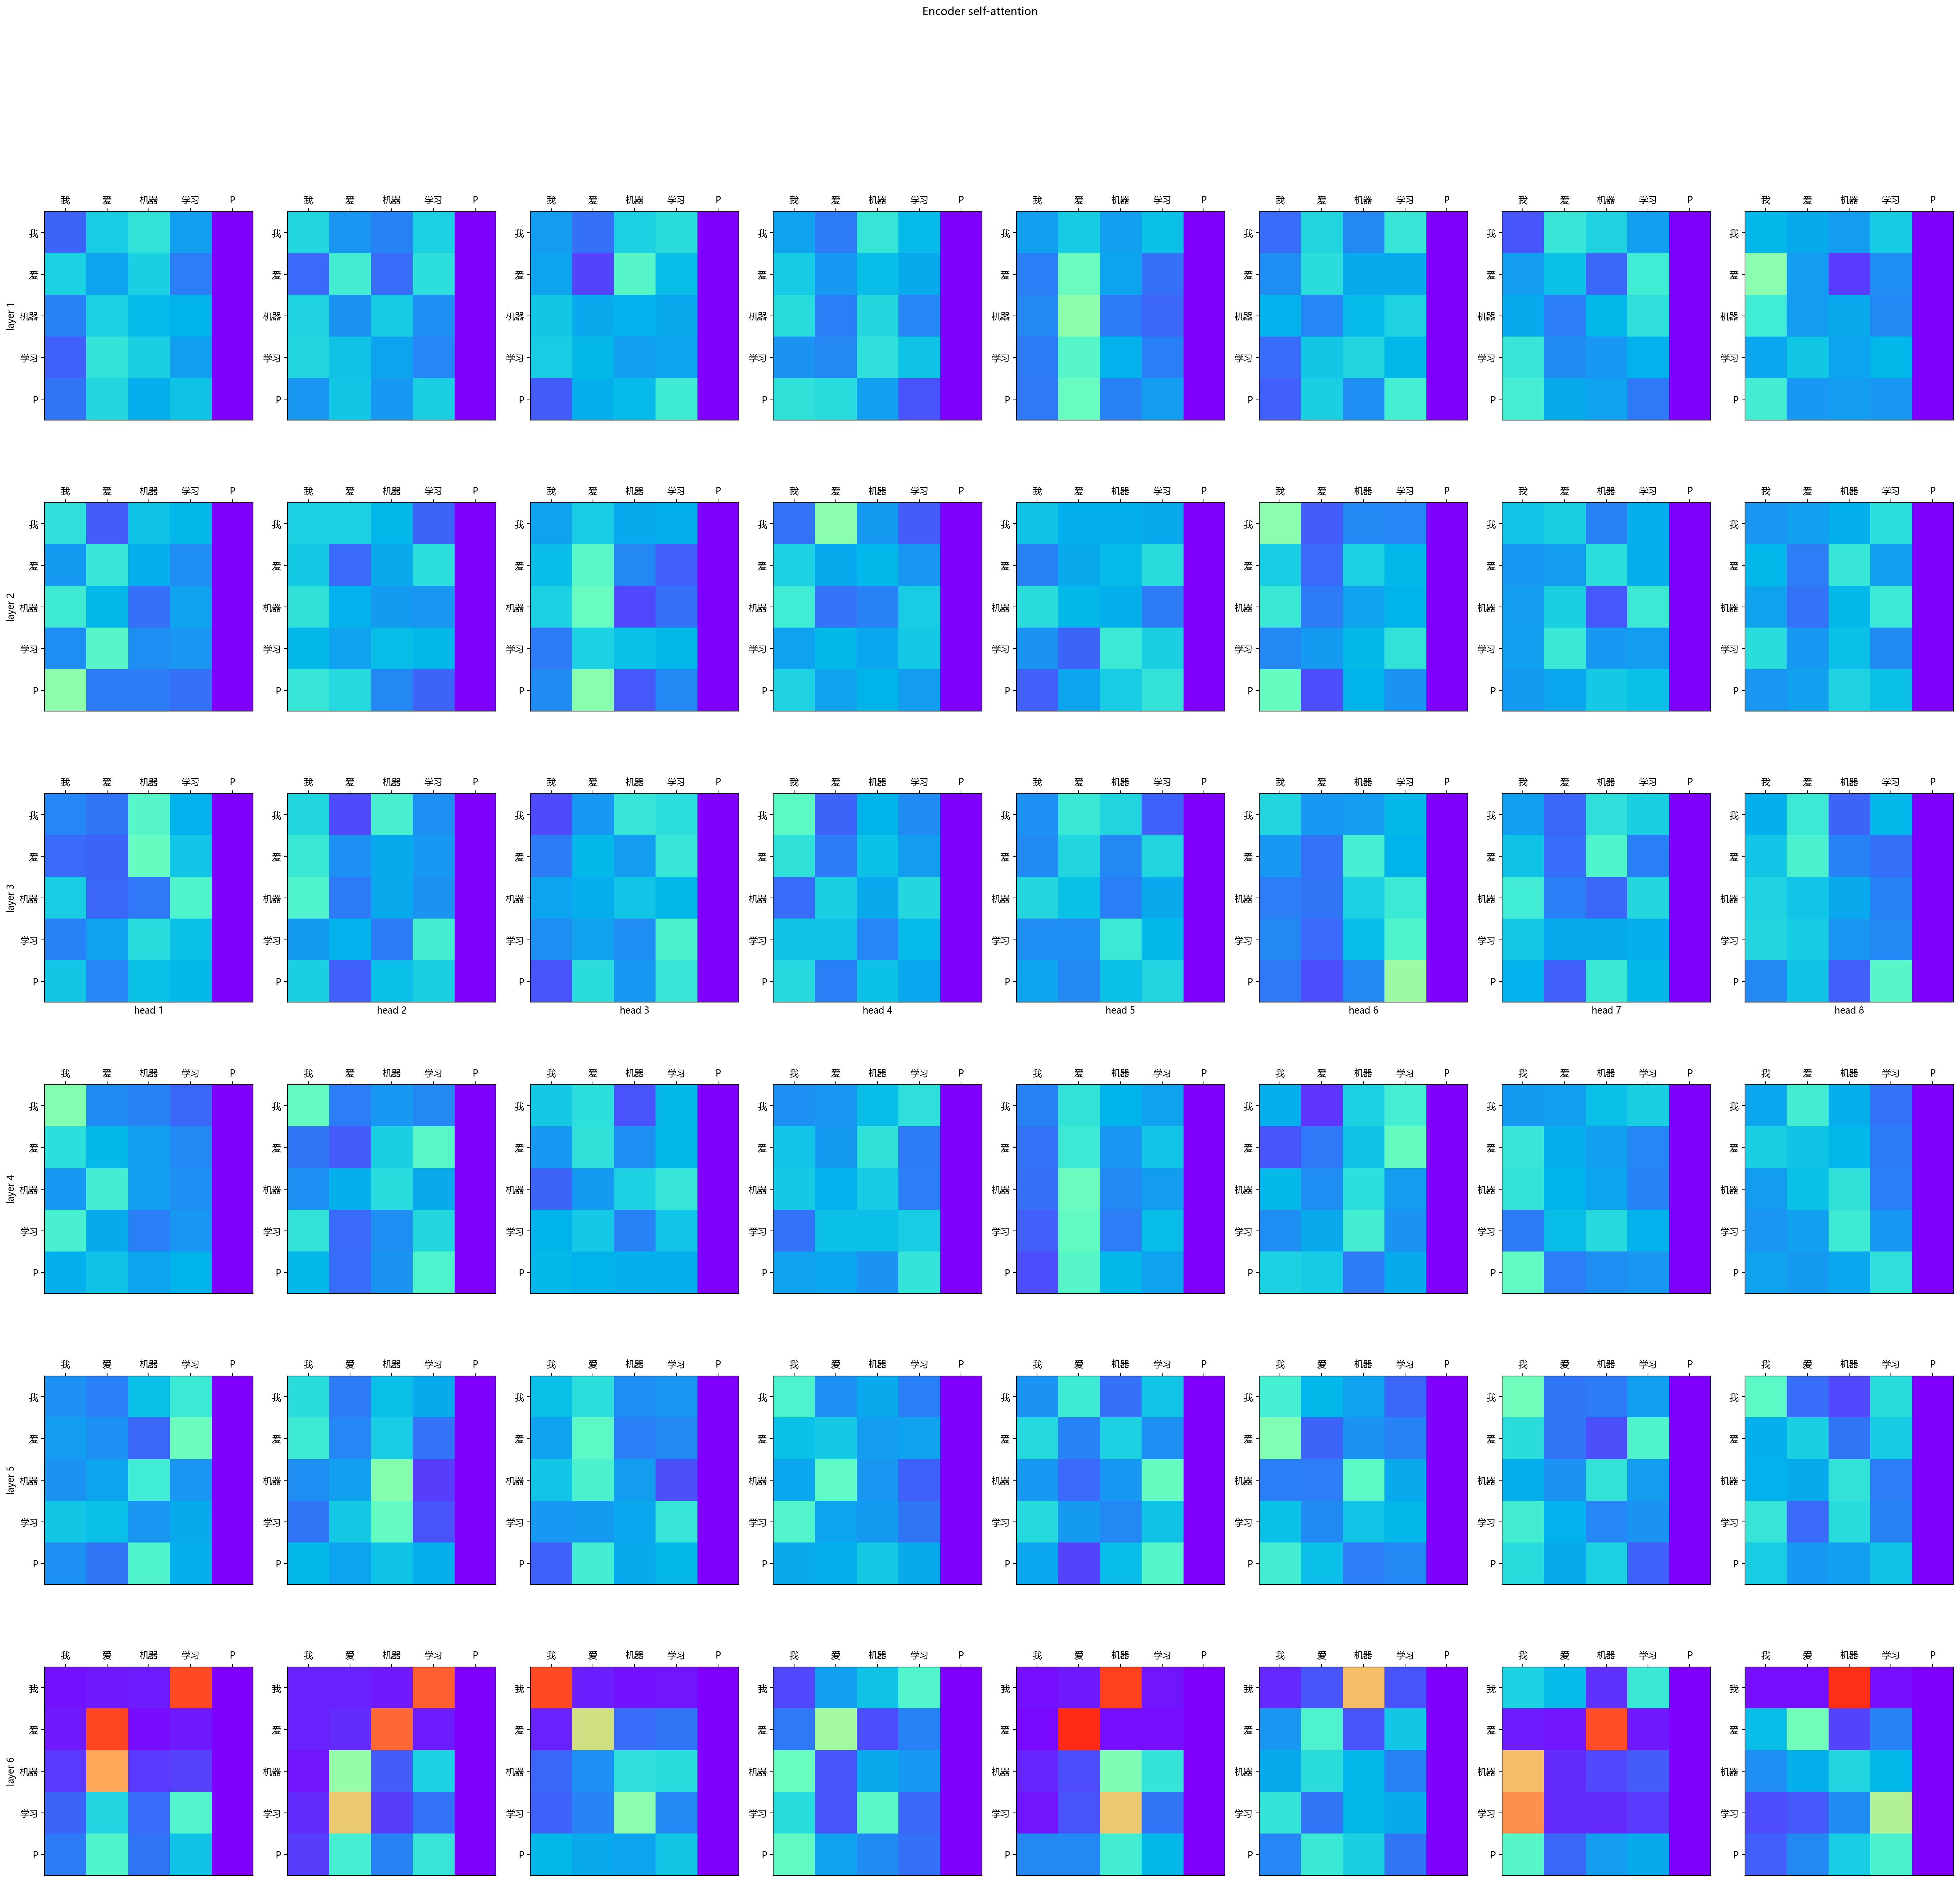

In [131]:
transformer_attention_matrix()

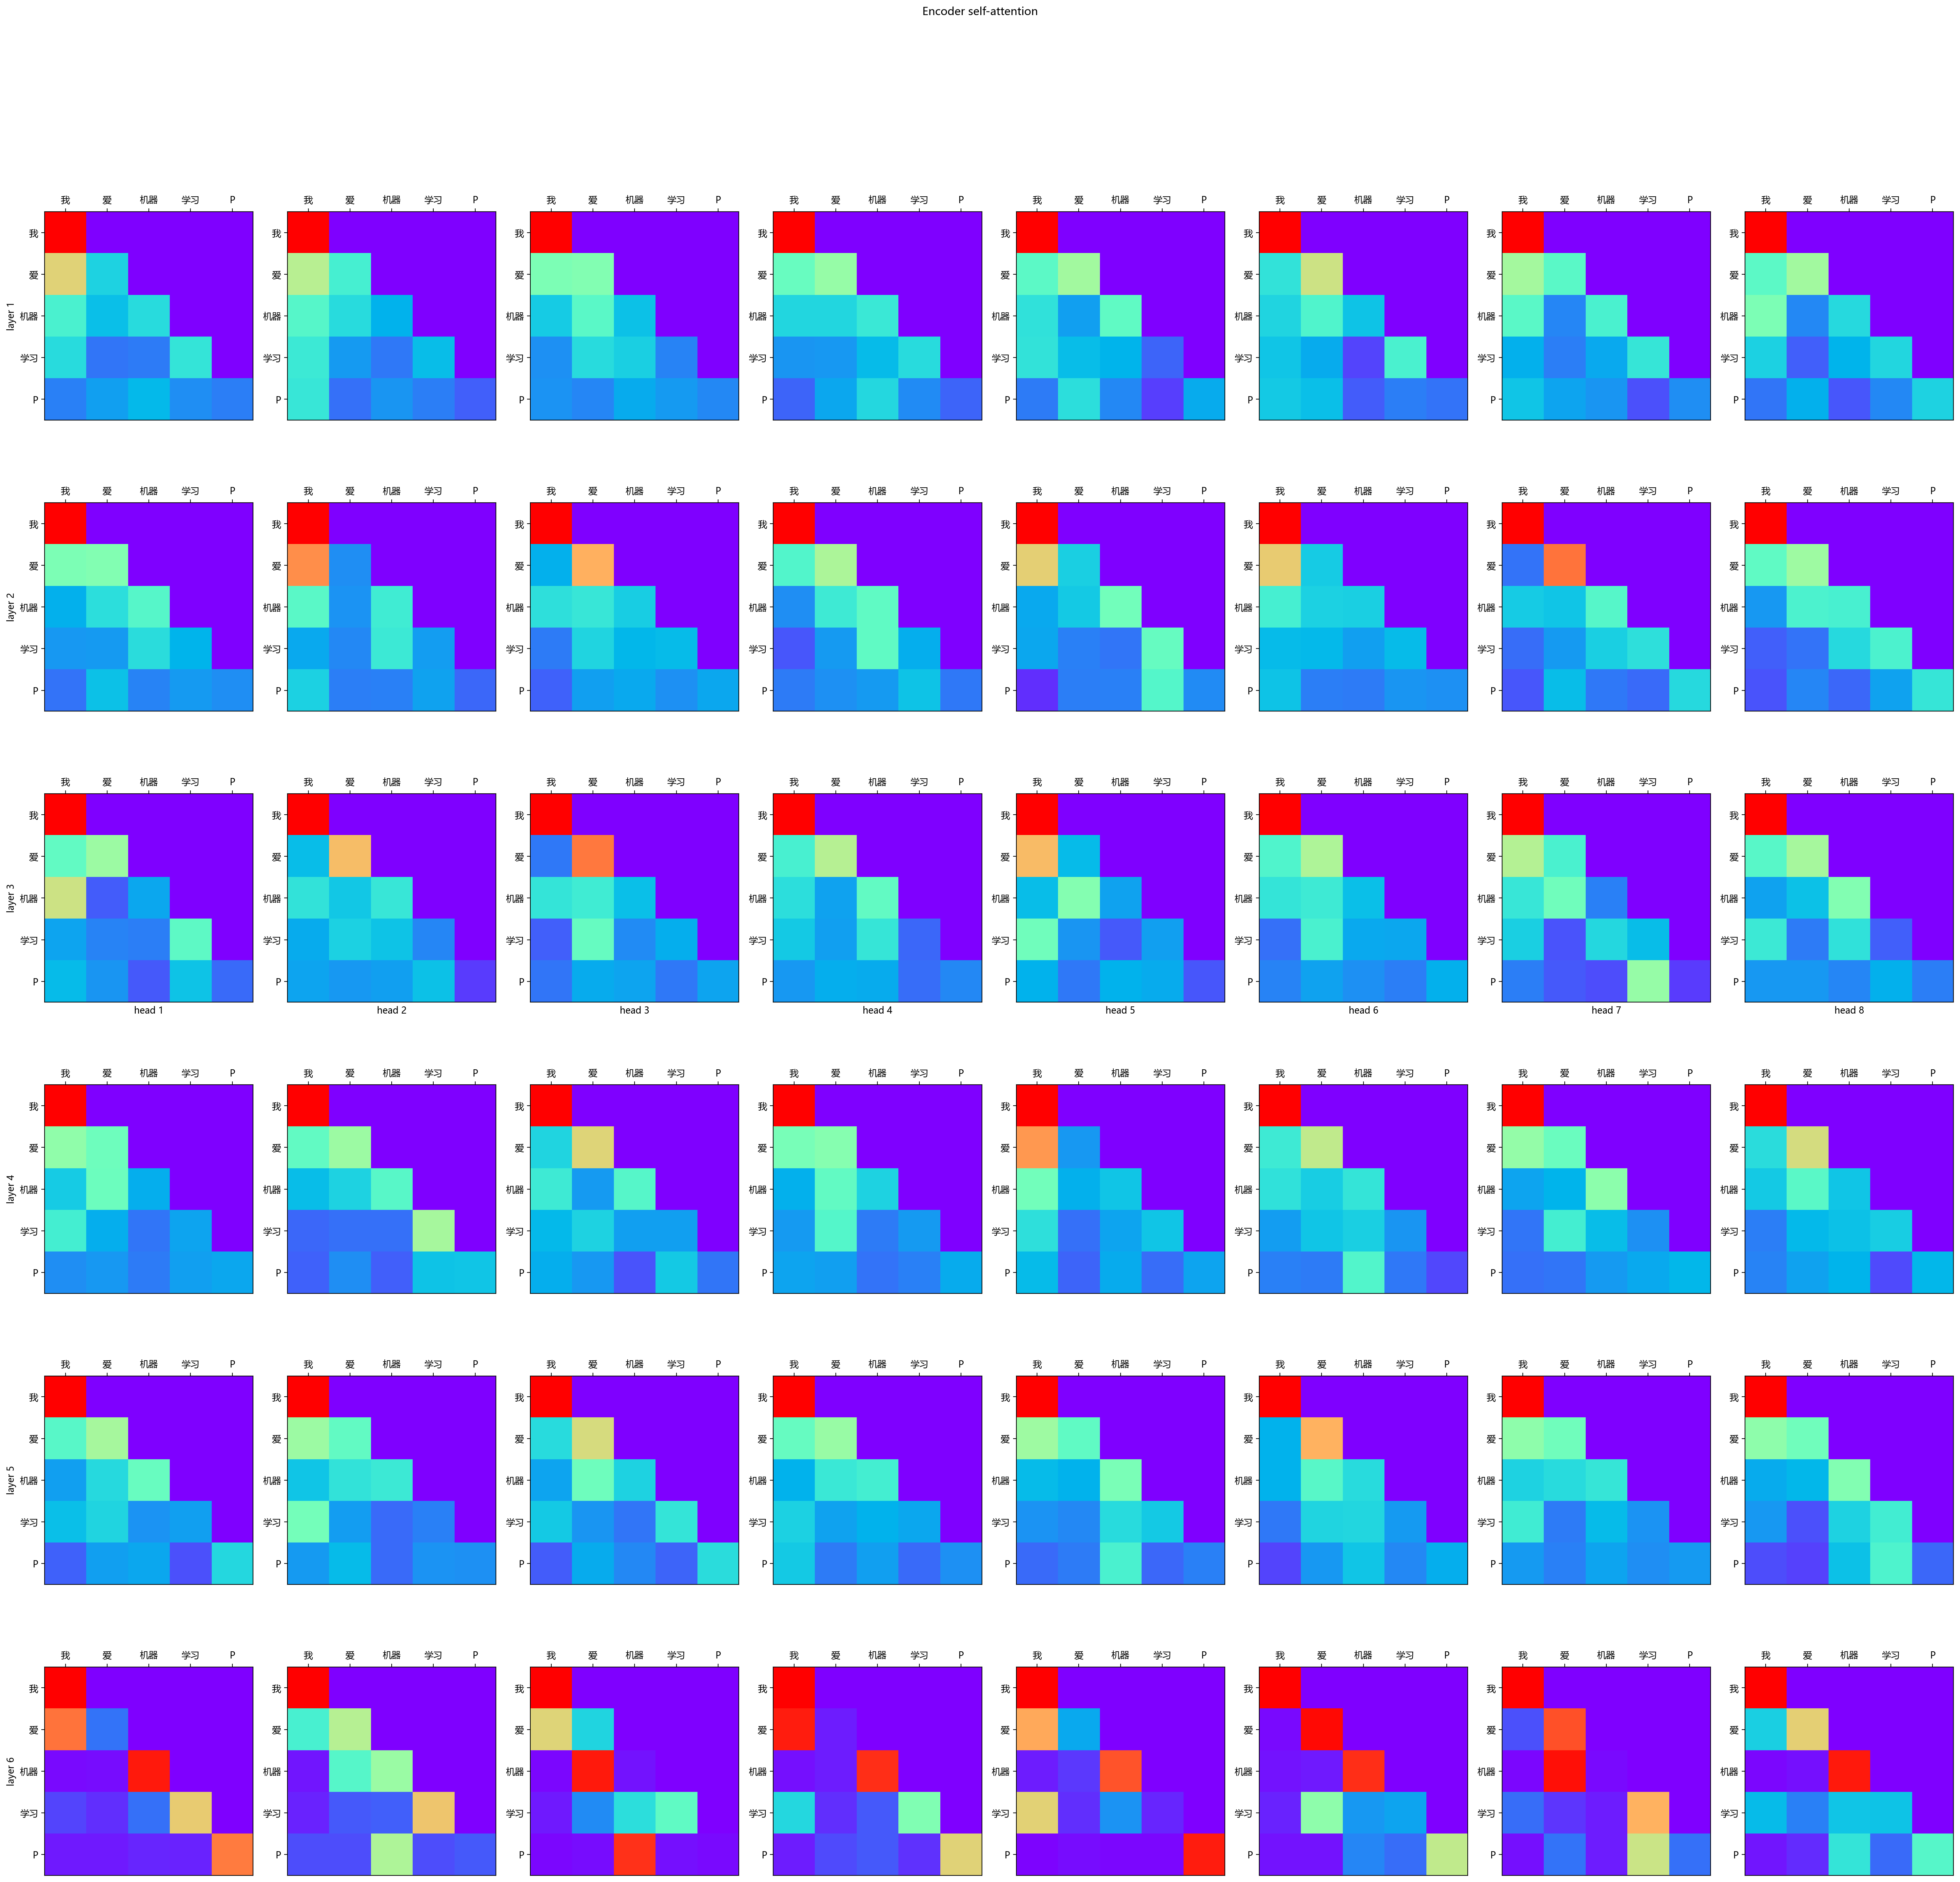

In [134]:
transformer_attention_matrix()

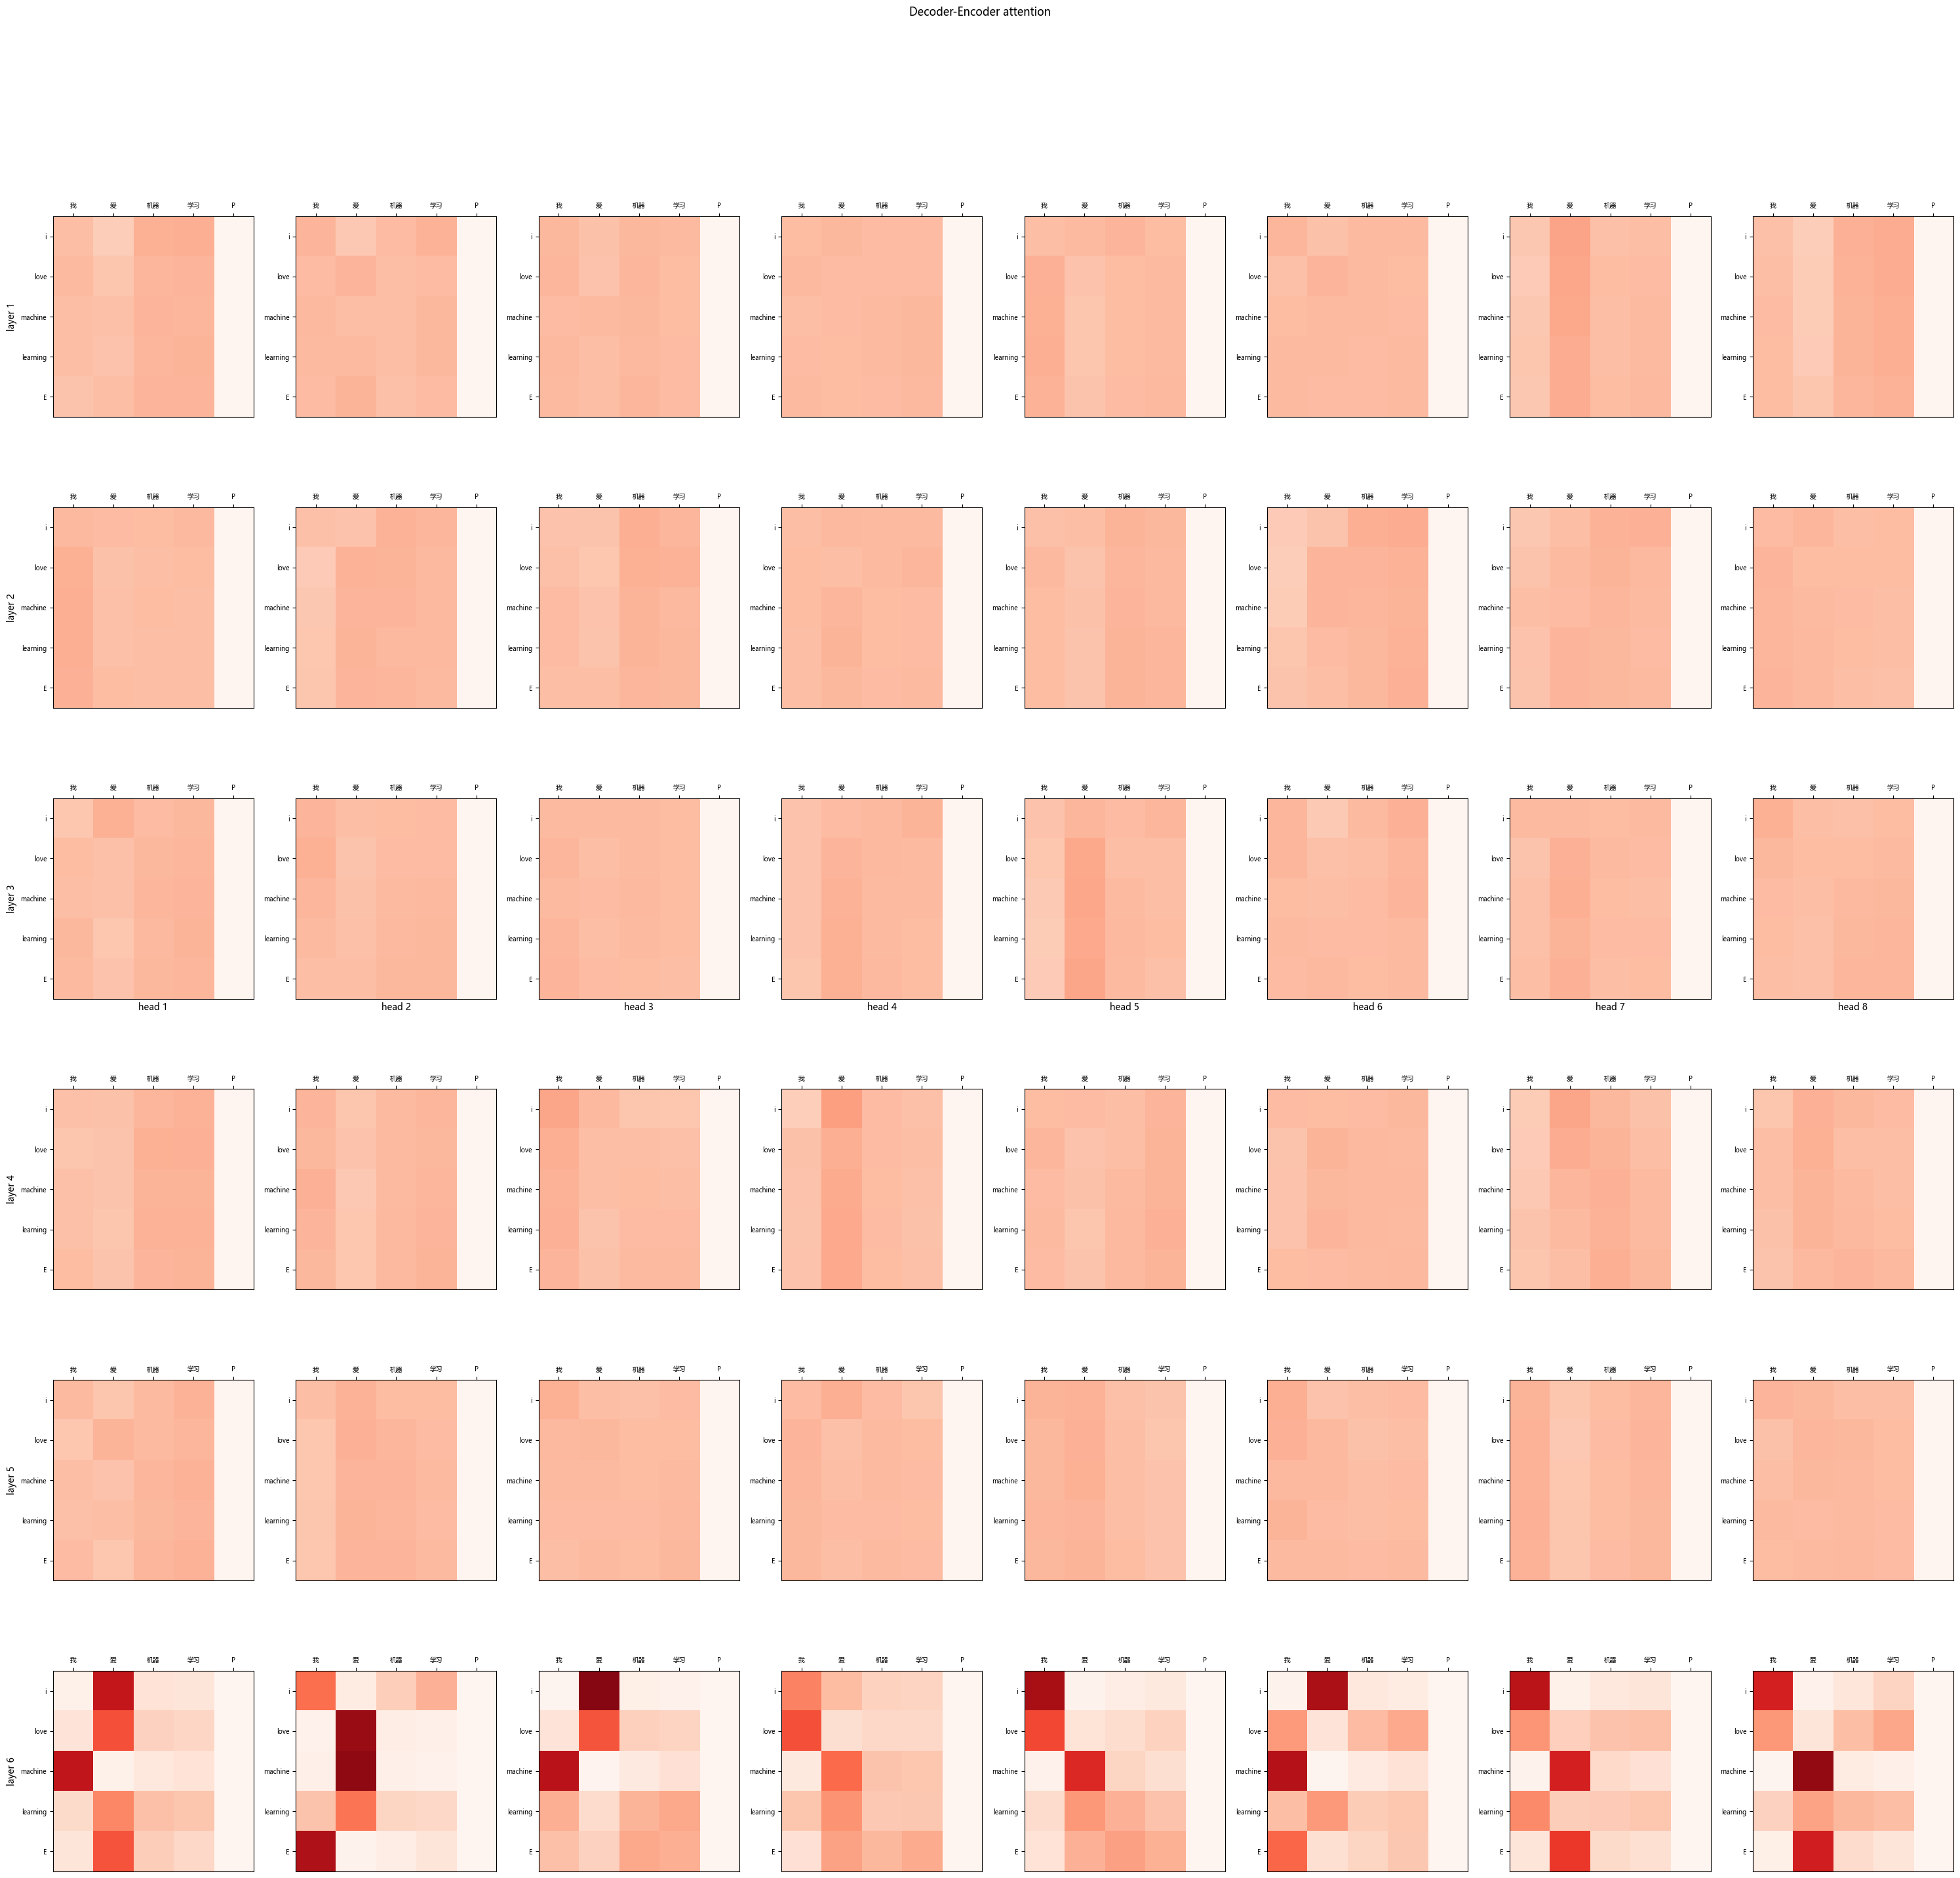

In [146]:
transformer_attention_matrix()

In [190]:
mask = torch.zeros(5,6,dtype=torch.float)

In [259]:
a = torch.randn(5,6)

x = [5,4,3,2,1]
mask = torch.zeros(5,6,dtype=torch.float)
for e_id, src_len in enumerate(x):
    mask[e_id, src_len:] = 1
mask = mask.to(device = 'cpu')
print(mask)
a.data.masked_fill_(mask.bool(),-np.inf)
print(a)

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.]])
tensor([[ 0.1931, -0.9161,  1.2195, -0.8646,  1.2443,    -inf],
        [ 0.6900,  0.8193, -0.0685,  0.7232,    -inf,    -inf],
        [ 0.3260,  0.2160, -1.6251,    -inf,    -inf,    -inf],
        [ 1.1199, -0.6386,    -inf,    -inf,    -inf,    -inf],
        [ 1.4108,    -inf,    -inf,    -inf,    -inf,    -inf]])


In [279]:
attn_shape = [5, 5]
# attn_shape: [batch_size, tgt_len, tgt_len]
subsequence_mask = np.triu(np.ones(attn_shape), k=1)  # 生成一个上三角矩阵
subsequence_mask = torch.from_numpy(subsequence_mask)

In [280]:
subsequence_mask

tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]], dtype=torch.float64)

In [283]:
a = torch.randn(128, 8, 5, 5)

In [285]:
a.masked_fill_(subsequence_mask.bool(),-np.inf)

tensor([[[[-8.0376e-01,        -inf,        -inf,        -inf,        -inf],
          [ 1.0697e+00, -2.6869e+00,        -inf,        -inf,        -inf],
          [-1.9440e-01, -7.7337e-02, -1.4543e+00,        -inf,        -inf],
          [-9.2704e-01, -2.0563e+00,  4.2110e-01,  3.5811e-01,        -inf],
          [ 6.9844e-02, -1.7362e+00, -7.0127e-01,  1.4039e-01,  1.7217e+00]],

         [[-5.4034e-01,        -inf,        -inf,        -inf,        -inf],
          [-1.2226e+00,  1.8711e+00,        -inf,        -inf,        -inf],
          [ 1.1235e+00, -1.0016e+00,  1.8371e-01,        -inf,        -inf],
          [ 5.4172e-01, -7.8419e-01, -3.6607e-01, -1.5059e+00,        -inf],
          [-1.5045e+00,  7.9493e-01, -1.6567e-01, -2.5240e-01, -9.7049e-02]],

         [[-1.0502e+00,        -inf,        -inf,        -inf,        -inf],
          [-1.8175e-01,  5.7572e-01,        -inf,        -inf,        -inf],
          [ 1.7086e-01, -8.4632e-01,  4.8386e-01,        -inf,        -i

In [271]:
subsequence_mask = torch.eq(subsequence_mask, 0).float().unsqueeze(0)

In [274]:
subsequence_mask

tensor([[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [275]:
mask = subsequence_mask.masked_fill_(subsequence_mask.bool(),-np.inf)

In [276]:
mask

tensor([[[0., -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf],
         [0., 0., 0., 0., -inf],
         [0., 0., 0., 0., 0.]]])

In [277]:
subsequence_mask = np.triu(np.ones(attn_shape), k=1)  # 生成一个上三角矩阵
subsequence_mask = torch.from_numpy(subsequence_mask).byte()

In [278]:
subsequence_mask

tensor([[0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]], dtype=torch.uint8)

In [187]:
mask = torch.eq(mask, 1)

In [188]:
mask

tensor([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]])

In [191]:
mask.masked_fill_(mask.,-np.inf)

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [192]:
mask

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [23]:
embeding = nn.Embedding(6, 512)

In [36]:
position = torch.arange(0, 500, dtype=torch.float).unsqueeze(1)

In [37]:
position.shape

torch.Size([500, 1])

In [39]:
max_len = 5000
pe = torch.zeros(max_len, d_model)
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
print(div_term.shape)
pe[:, 0::2] = torch.sin(position * div_term)## 这里需要注意的是pe[:, 0::2]这个用法，就是从0开始到最后面，补长为2，其实代表的就是偶数位置
pe[:, 1::2] = torch.cos(position * div_term)##这里需要注意的是pe[:, 1::2]这个用法，就是从1开始到最后面，补长为2，其实代表的就是奇数位置
## 上面代码获取之后得到的pe:[max_len*d_model]
print(pe.shape)
## 下面这个代码之后，我们得到的pe形状是：[max_len*1*d_model]
pe = pe.unsqueeze(0).transpose(0, 1)
print(pe.shape)

torch.Size([256])
torch.Size([5000, 512])
torch.Size([5000, 1, 512])


In [42]:
pos = np.arange(max_len)[:, None]

In [43]:
pos.shape

(5000, 1)

In [63]:
pos = np.arange(max_len)[:, None]  # [max_len, 1]扩展一个维度为了后面矩阵运算
pe = pos / np.power(10000, 2. * np.arange(d_model)[None, :] / d_model)  
pe[:, 0::2] = np.sin(pe[:, 0::2])
pe[:, 1::2] = np.cos(pe[:, 1::2])  
# [max_len, dim]
pe = torch.tensor(pe, dtype=torch.float)
pe = pe.unsqueeze(0).transpose(0, 1)
pe = pe[:128, :]

In [64]:
pe.shape

torch.Size([128, 1, 512])

In [112]:
embedding = nn.Embedding(5, 512)

In [114]:
x = torch.LongTensor(torch.rand(1, 5).long())    # embedding不能接收负数输入 rand(0, 1)取数

In [115]:
output = embedding(x)

In [116]:
output.shape

torch.Size([1, 5, 512])

In [105]:
input.unsqueeze(0)

tensor([[[1, 2, 4, 5],
         [4, 3, 2, 9]]])

In [106]:
input

tensor([[1, 2, 4, 5],
        [4, 3, 2, 9]])

In [107]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

In [108]:
input_batch = [[src_vocab[n] for n in sentences[0].split()]]
output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]

In [111]:
input_batch

[[1, 2, 3, 4, 0]]

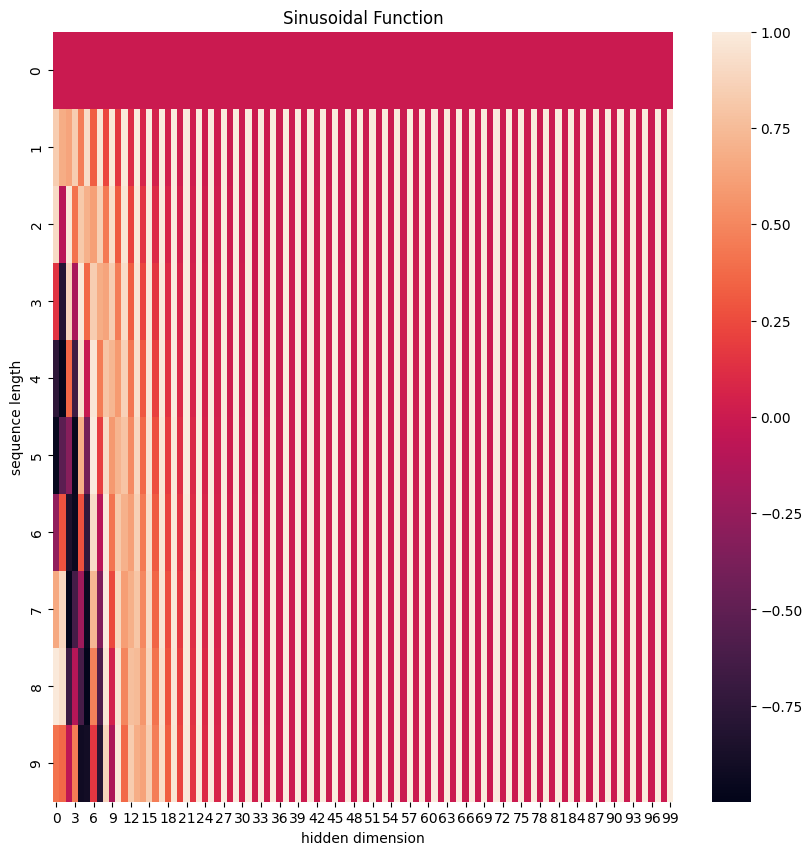

In [293]:
# 下面画一下位置嵌入，纵向观察，可见随着e m b e d d i n g   d i m e n s i o n embedding \ dimensionembedding dimension序号增大，
# 位置嵌入函数的周期变化越来越平缓
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

def get_positional_encoding(max_seq_len, embed_dim):
    # 初始化一个positional encoding
    # embed_dim: 字嵌入的维度
    # max_seq_len: 最大的序列长度
    positional_encoding = np.array([
        [pos / np.power(10000, 2 * i / embed_dim) for i in range(embed_dim)]
        if pos != 0 else np.zeros(embed_dim) for pos in range(max_seq_len)])
    
    positional_encoding[1:, 0::2] = np.sin(positional_encoding[1:, 0::2])  # dim 2i 偶数
    positional_encoding[1:, 1::2] = np.cos(positional_encoding[1:, 1::2])  # dim 2i+1 奇数
    return positional_encoding

positional_encoding = get_positional_encoding(max_seq_len=10, embed_dim=100)
plt.figure(figsize=(10,10))
sns.heatmap(positional_encoding)
plt.title("Sinusoidal Function")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")
plt.show()